In [2]:
from osgeo import gdal
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pwd = str(pathlib.Path.cwd().parent)

In [4]:
image_path = pwd + "/data/source_images/Post_Event_San_Juan.tif"
image_path

'/Users/sashikanth/Documents/sushi/sushi_personal/sandmining_prediction/eye-for-detail/data/source_images/Post_Event_San_Juan.tif'

In [5]:
ds = gdal.Open(image_path)
ds

/Users/sashikanth/miniconda3/envs/gdal-geospatial/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x15106fb70> >

In [6]:
ds.GetProjectionRef()

'PROJCS["WGS 84 / UTM zone 19N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32619"]]'

In [7]:
def generate_tiles(input_file, output_dir, grid_x, grid_y):
    ds = gdal.Open(input_file)
    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    x_offset = np.random.randint(0, width - grid_x)
    y_offset = np.random.randint(0, height - grid_y)

    tile_width = min(grid_x, width - x_offset)
    tile_height = min(grid_y, height - y_offset)

    tile = []
    for band in range(1, num_bands + 1):
        tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
        tile.append(tile_data)

    # Create output filename
    output_file = os.path.join(output_dir, f"tile.tif")
        
    # Create an output TIFF file with same CRS and band values range
    driver = gdal.GetDriverByName("GTiff")
    options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
    out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                ds.GetRasterBand(1).DataType, options=options)
    # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

    # Set the geotransform
    geotransform = list(ds.GetGeoTransform())
    geotransform[0] = geotransform[0] + x_offset * geotransform[1]
    geotransform[3] = geotransform[3] + y_offset * geotransform[5]
    out_ds.SetGeoTransform(tuple(geotransform))
    print(geotransform)

    # Set the projection
    out_ds.SetProjection(ds.GetProjection())

    # Write each band to the output file
    for band in range(1, num_bands + 1):
        out_band = out_ds.GetRasterBand(band)
        out_band.WriteArray(tile[band - 1])

    # Close the output file
    out_ds = None

    print("Tiles generation completed.")

def get_image_array(tiff_file):
    if isinstance(tiff_file, str):
        tiff_file = gdal.Open(tiff_file, gdal.GA_ReadOnly) 
    bands = []
    for i in range(1, 4):
        bands.append(tiff_file.GetRasterBand(i).ReadAsArray())
    bands = np.array(bands).transpose(2, 1, 0)
    return bands
    
def visualize_geotiff(tiff_file):
    bands = get_image_array(tiff_file)
    plt.imshow(bands)
    

# Takes around 5 gb memory so be wary
output_dir = "."
grid_x = 512
grid_y = 512

Total number of tiles: 10730
[797531.740235975, 0.30517578125, 0.0, 2032330.6258482812, 0.0, -0.30517578125]
Tiles generation completed.


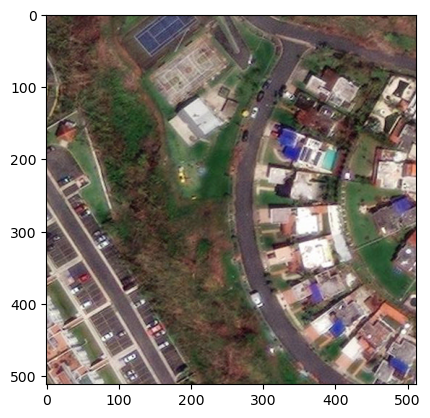

In [8]:
np.random.seed(0)
generate_tiles(image_path, output_dir, grid_x, grid_y)
dataset = gdal.Open('tile.tif', gdal.GA_ReadOnly) 
visualize_geotiff(dataset)

In [9]:
dataset.GetProjectionRef()

'PROJCS["WGS 84 / UTM zone 19N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32619"]]'

In [10]:
import geopandas as gpd

In [11]:
buildings = gpd.read_file("./../data/buildings-footprints-roi")
buildings

,latitude,longitude,area_in_me,confidence,full_plus_,geometry
0,18.448569,-66.146916,None,0.7140,77CMCVX3+C6GP,"POLYGON ((167578.511 2042703.134, 167575.734 2..."
1,18.411424,-66.182499,None,0.8935,77CMCR69+H26R,"POLYGON ((163749.148 2038647.349, 163737.189 2..."
2,18.429443,-66.167636,None,0.8074,77CMCRHJ+QWHP,"POLYGON ((165354.588 2040621.133, 165350.801 2..."
3,18.371113,-66.119793,None,0.8103,77CM9VCJ+C3WG,"POLYGON ((170294.617 2034071.175, 170289.741 2..."
4,18.418506,-66.172524,None,0.8449,77CMCR9G+CX56,"POLYGON ((164821.285 2039417.821, 164806.291 2..."
...,...,...,...,...,...,...
281567,18.438485,-66.119304,None,0.7072,77CMCVQJ+97WF,"POLYGON ((170479.843 2041537.071, 170474.647 2..."
281568,18.417240,-66.164903,None,0.6713,77CMCR8P+V2XC,"POLYGON ((165618.117 2039265.732, 165611.185 2..."
281569,18.396331,-66.119886,None,0.7770,77CM9VWJ+G2Q8,"POLYGON ((170344.030 2036873.416, 170329.004 2..."
281570,18.390318,-66.178915,None,0.8523,77CM9RRC+4CGP,"POLYGON ((164091.330 2036312.981, 164081.023 2..."


In [12]:
import shapely

In [13]:
def points_from_bounds(minx, miny, maxx, maxy):
    return [(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy)]

sampled_image_bounds = points_from_bounds(*(163416.08392746712, 2032975.2213089266, 163572.38155287475, 2032818.923683519))
sampled_image_bounds

[(163416.08392746712, 2032975.2213089266),
 (163572.38155287475, 2032975.2213089266),
 (163572.38155287475, 2032818.923683519),
 (163416.08392746712, 2032818.923683519)]

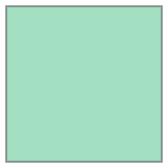

In [14]:
sampled_image_polygon = shapely.Polygon(sampled_image_bounds)
sampled_image_polygon

In [51]:
buildings_in_sampled_image = buildings[buildings.within(sampled_image_polygon)]
buildings_in_sampled_image

,latitude,longitude,area_in_me,confidence,full_plus_,geometry
6181,18.358966,-66.183541,None,0.8167,77CM9R58+HHPP,"POLYGON ((163536.953 2032848.813, 163533.217 2..."
11849,18.358979,-66.183807,None,0.8231,77CM9R58+HFW2,"POLYGON ((163497.409 2032852.244, 163508.416 2..."
19571,18.359778,-66.183262,None,0.7136,77CM9R58+WM94,"POLYGON ((163566.546 2032939.715, 163561.812 2..."
37898,18.359138,-66.183954,None,0.7695,77CM9R58+MC3F,"POLYGON ((163493.561 2032863.122, 163482.894 2..."
38932,18.359004,-66.184345,None,0.8269,77CM9R58+J725,"POLYGON ((163452.373 2032850.423, 163442.982 2..."
41580,18.358807,-66.183356,None,0.8635,77CM9R58+GMC8,"POLYGON ((163549.696 2032835.821, 163555.638 2..."
65363,18.358908,-66.183450,None,0.7863,77CM9R58+HJ78,"POLYGON ((163547.632 2032838.995, 163542.902 2..."
66944,18.359074,-66.183523,None,0.8019,77CM9R58+JHHV,"POLYGON ((163537.193 2032860.610, 163534.472 2..."
67755,18.358992,-66.184199,None,0.8286,77CM9R58+H8VP,"POLYGON ((163467.043 2032850.188, 163457.993 2..."
95812,18.358859,-66.183455,None,0.7464,77CM9R58+GJV7,"POLYGON ((163542.902 2032834.379, 163540.462 2..."


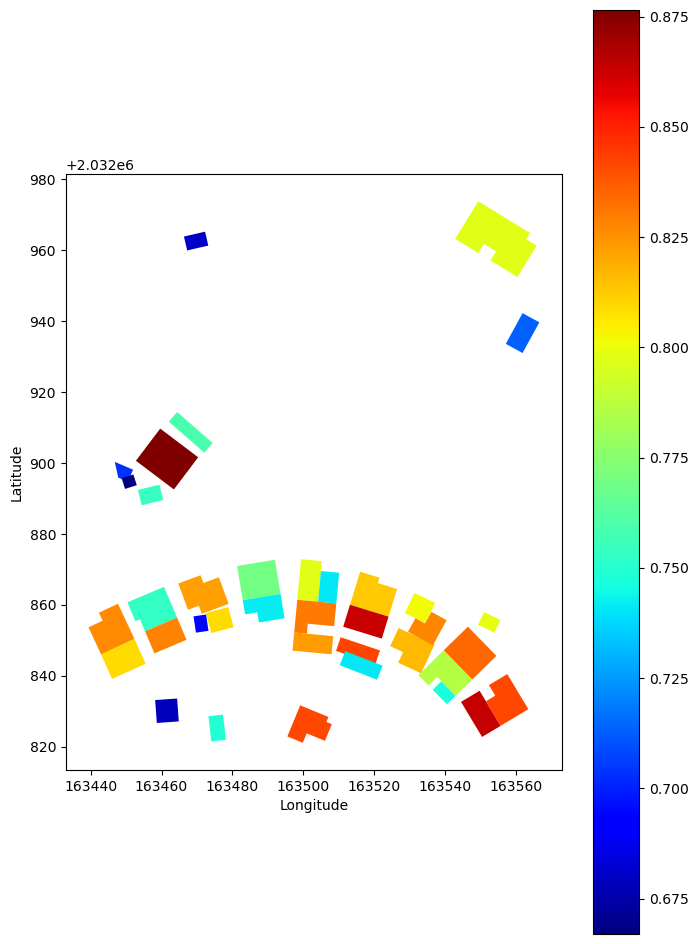

In [53]:
fig, ax = plt.subplots(1, figsize=(8, 12))
buildings_in_sampled_image.plot(ax=ax, column="confidence", cmap="jet", legend=True)
# shapefile.plot(ax=ax, cmap="jet", legend=True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [63]:
import rasterio
from rasterio.enums import MergeAlg
from rasterio import features

In [66]:
def rasterize(raster_path, shapefile):
    with rasterio.open(raster_path, "r") as src:
        # Get the CRS of the raster
        raster_crs = src.crs

        # Reproject the geometries
        shapefile = shapefile.to_crs(raster_crs)

        # Get list of geometries for all features in vector file
        geom = [shapes for shapes in shapefile.geometry]

        # Rasterize vector using the shape and coordinate system of the raster
        rasterized = features.rasterize(geom,
                                        out_shape = src.shape,
                                        fill = 0,
                                        out = None,
                                        transform = src.transform,
                                        all_touched = True,
                                        merge_alg=MergeAlg.add,
                                        default_value = 255,
                                        dtype = None)
        return rasterized
    
rasterized_buildings = rasterize("tile.tif", buildings_in_sampled_image)

In [121]:
from PIL import Image

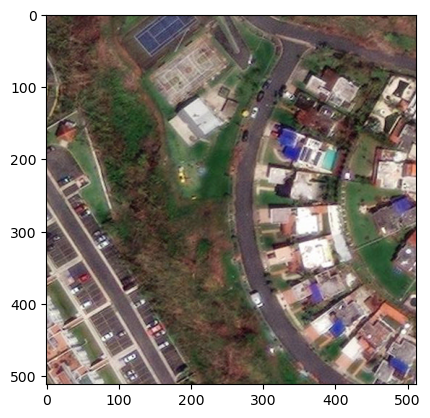

In [130]:
visualize_geotiff(dataset)

In [127]:
image_data = get_image_array(dataset)
image = Image.fromarray(image_data)
# image = image.rotate(-90)
image = image.transpose(Image.FLIP_LEFT_RIGHT)
image = image.rotate(90)
image_data = np.asarray(image).copy()

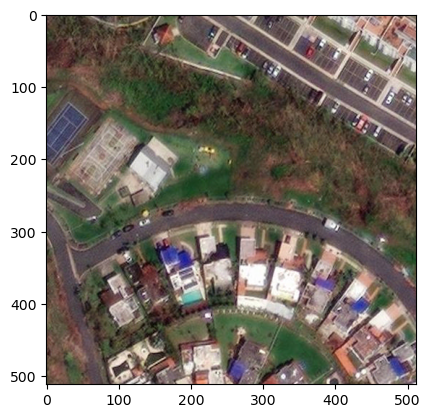

In [128]:
plt.imshow(image_data)

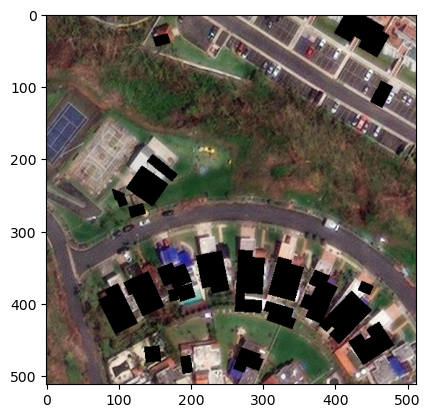

In [129]:
image_data[rasterized_buildings != 0] = 0
plt.imshow(image_data)